# Code to Solve the Image Deblurring Problem

## Problem formulation

$\boldsymbol{y} = \boldsymbol{S} \left( \boldsymbol{b} \circledast \boldsymbol{x} + \boldsymbol{\varepsilon} \right) = \boldsymbol{S} \left( \mathcal{C} (\boldsymbol{b})\boldsymbol{x} + \boldsymbol{\varepsilon} \right), \hspace{2ex} \boldsymbol{\varepsilon} \sim \mathcal{N} (0, \sigma^2 \boldsymbol{I}), \hspace{2ex} \sigma \geq 0.$

- $\boldsymbol{x} \in \mathbb{R}^{n}$: (vectorized) unknown image to recover 
- $\boldsymbol{b} \in \mathbb{R}^{n}$: (vectorized) blurring kernel
- $\mathcal{C}(\boldsymbol{b})$ : circulant matrix of $\boldsymbol{b}$
- $\boldsymbol{\varepsilon} \in \mathbb{R}^{m}$: noise
- $ \sigma \in \mathbb{R}^+$: noise level 
- $ \boldsymbol{y} \in \mathbb{R}^{n}$: observed measurements
- $ \circledast : \mathbb{R}^{n} \times \mathbb{R}^{n} \mapsto \mathbb{R}^{n}$: denotes cicular convolution (https://en.wikipedia.org/wiki/Convolution)
- $ \boldsymbol{S} \in \mathbb{R}^{m} \times \mathbb{R}^{n}$: subsampling matrix

## Loss function, gradients

### Loss function:

$\ell ({\boldsymbol{x}}) = \frac{1}{2m} \| \boldsymbol{y} - \boldsymbol{S} \mathcal{C} (\boldsymbol{b})\boldsymbol{x} \|_2^2$

### Loss function as a finite sum:

$\ell (\boldsymbol{x}) := \frac{1}{m} \sum_i^m \ell_{i}(\boldsymbol{x}) = \frac{1}{m}\sum_i^m \frac{1}{2}(y_i - \mathcal{C}_i(\boldsymbol{b}) \boldsymbol{x})^2$

- $\mathcal{C}_i(\boldsymbol{b})$ denotes the $i^{\text{th}}$ row of the circulant matrix of $\boldsymbol{b}$

### Full gradient:

$\nabla \ell ({\boldsymbol{x}}) = \frac{1}{m} \boldsymbol{S}^\top \mathcal{C} (\boldsymbol{b})^\top ( \boldsymbol{S} \mathcal{C} (\boldsymbol{b}) \boldsymbol{x} - \boldsymbol{y} ) $

### Stochastic gradient:

$\nabla \ell_{i}({\boldsymbol{x}}) = \boldsymbol{S}^\top_i \mathcal{C} (\boldsymbol{b})^\top_i (\boldsymbol{x}^\top \mathcal{C}_i(\boldsymbol{b}) - y_i ) $


In [1]:
from ipynb.fs.full.deblurring_gradients import full_grad , stoch_grad, get_batch

(2048, 4096)
(2048,)
(2048,)
(2048,)
[-2.14277179e-06 -2.54106590e-06 -2.60645879e-06 ...  3.82724465e-07
 -4.27212399e-07 -1.44288242e-06]
[-2.14277179e-06 -2.54106590e-06 -2.60645879e-06 ...  3.82724465e-07
 -4.27212399e-07 -1.44288242e-06]
[0. 0. 0. ... 0. 0. 0.] [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [2]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from os.path import dirname, abspath
import os
import matplotlib.pyplot as plt
from PIL import Image
import time

from skimage import data, img_as_float
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.metrics import peak_signal_noise_ratio
from skimage.util import random_noise

from scipy.linalg import circulant

In [4]:
np.random.seed(0)

## Set paths
data_path="../data/Set12/"
save_path="./figures/"
blur_path="./"
image_list = sorted(os.listdir(data_path))
blur_list = sorted(os.listdir(blur_path))

# set image and blurring kernel size
H = 64
W = 64

## Read test image
# normalize image pixels in range [0,1]
# orig = np.array(Image.open(data_path + image_list[8])) / 225.0
ORIG = Image.open(data_path + image_list[7]).resize((H,W))
ORIG = np.array(ORIG) / 255.0
mintmp = np.min(ORIG)
maxtmp = np.max(ORIG)
ORIG = (ORIG - mintmp) / (maxtmp - mintmp)

## Read blurring kernel
blur = Image.open(blur_path + blur_list[2]).resize((H,W))

(-0.5, 63.5, 63.5, -0.5)

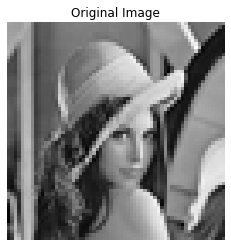

In [5]:
orig_fig = plt.figure()
ax = orig_fig.add_subplot(1, 1, 1)
orig_plot = plt.imshow(ORIG, cmap='gray', vmin=0, vmax=1)
ax.set_title('Original Image')
ax.axis('off')

(-0.5, 63.5, 63.5, -0.5)

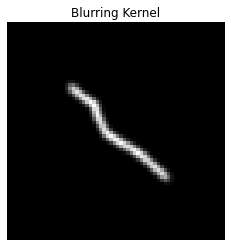

In [6]:
blur_fig = plt.figure()
ax = blur_fig.add_subplot(1, 1, 1)
blur_plot = plt.imshow(blur, cmap='gray')
ax.set_title('Blurring Kernel')
ax.axis('off')

In [7]:
## Set signal model parameters
H, W = ORIG.shape[:2] 				# height and width of orig image
N = H*W 							# image dimension
sigma = 100							# noise level of measurements

## Create noise
noises = np.random.normal(0, sigma, (N,))

## Create cirulant matrix
vb = np.matrix.flatten(np.asarray(blur)) # flatten blurring kernel into a vector
Cb = circulant(vb) # create circulant matrix of v_b
Cb_inv = np.linalg.inv(Cb)

## Vectorize orig image
vorig = np.matrix.flatten(np.asarray(ORIG))

# Test problem without subsampling for sanity checking of problem formulation

Expected results: no noise --> perfect recovery

[ 2.22715180e-11 -2.55683918e-10  2.07485140e-10 ...  1.41038431e-11
  2.95360958e-12 -2.18412510e-11]


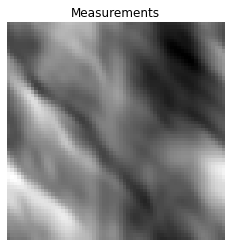

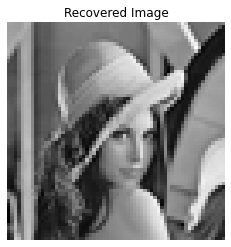

In [8]:
## Create measurements
y = np.matmul(Cb, vorig)

# Visualize blurry measurements
mintmp = np.min(y)
maxtmp = np.max(y)
y_v = (y - mintmp) / (maxtmp - mintmp)

blurred_fig = plt.figure()
ax = blurred_fig.add_subplot(1, 1, 1)
blurred_plot = plt.imshow(y_v.reshape((H,W)), cmap='gray', vmin=0, vmax=1)
ax.set_title('Measurements')
ax.axis('off')

## compute x = Cb_inv * y
x_init = np.linalg.inv(Cb).dot(y)
# mintmp = np.min(x_init)
# maxtmp = np.max(x_init)
# x_init = (x_init - mintmp) / (maxtmp - mintmp)
x = np.copy(x_init)

init_fig = plt.figure()
ax = init_fig.add_subplot(1, 1, 1)
init_plot = plt.imshow(x_init.reshape((H,W)), cmap='gray', vmin=0, vmax=1)
ax.set_title('Recovered Image')
ax.axis('off')

print(x_init - vorig)

# Introduce subsampled image deblurring problem

In [9]:
## Create noisy measurements
s = 2 # subsampling rate
y0 = Cb.dot(vorig) + noises
xinit = np.linalg.inv(Cb).dot(y0)

y = y0[::s]
print(y.size)
y_zpad = np.zeros((N,))
y_zpad[::s] = y0[::s] # zero pad for visualization


2048


In [10]:
## Precompute essential matrices
idx = np.arange(0, H*W, s)
S_Cb = Cb[idx,:]
print(S_Cb.shape)
S_Cb_pinv = np.linalg.pinv(S_Cb)
L = np.linalg.norm(S_Cb, 'f')
print(L)

(2048, 4096)
19859.29384444472


(-0.5, 63.5, 63.5, -0.5)

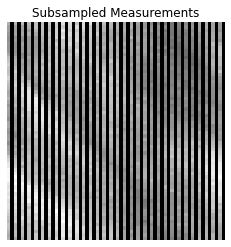

In [11]:
# Visualize blurry measurements with zero-padding
mintmp = np.min(y_zpad)
maxtmp = np.max(y_zpad)
y_zpad_v = (y_zpad - mintmp) / (maxtmp - mintmp)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plot = plt.imshow(y_zpad_v.reshape((H,W)), cmap='gray', vmin=0, vmax=1)
ax.set_title('Subsampled Measurements')
ax.axis('off')

[0.62982    0.53727108 0.35833258 ... 0.42678018 0.4017514  0.32299559] [0.6372549  0.62745098 0.61764706 ... 0.11764706 0.12745098 0.26470588]


(-0.5, 63.5, 63.5, -0.5)

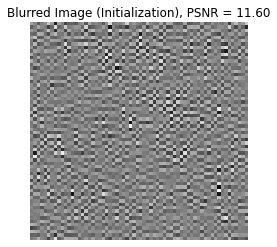

In [12]:
## Visualize naive initialization
x_init = S_Cb_pinv.dot(y)
mintmp = np.min(x_init)
maxtmp = np.max(x_init)
x_init = (x_init - mintmp) / (maxtmp - mintmp)
print(x_init, vorig)

init_fig = plt.figure()
ax = init_fig.add_subplot(1, 1, 1)
init_plot = plt.imshow(x_init.reshape((H,W)), cmap='gray', vmin=0, vmax=1)
ax.set_title(f'Blurred Image (Initialization), PSNR = {peak_signal_noise_ratio(x_init.reshape((H,W)), ORIG):0.2f}')
ax.axis('off')

In [13]:
def PnP_SVRG_Deblur(z, SCb, V1, V2, meas, eta, T1, T2, batch_size, FILTER, patch, orig):
    H, W = orig.shape[:2]
    time_per_iter = []
    psnr_per_iter = []
    t0 = 0

    ## Main PnP SVRG routine
    for i in range(T_outer):
        ## outer loop
        mu = np.real(full_grad(z, meas, V1, V2))	# Average gradient
        w = np.copy(z) 					# reference point
        start_iter = time.time()
        for j in range(T_inner):
            ## inner loop
            # prep matrices for batch
            BAT = np.random.choice(meas.size, batch_size, replace=False)

            W1 = np.zeros(SCb.shape[:2])
            W1[BAT,:] = SCb[BAT,:]

            meas_bat = np.zeros(SCb.shape[0])
            meas_bat[BAT] = meas[BAT]

            # stoch grad update
            start_grad = time.time()
            
            v = stoch_grad(z, meas_bat, W1, V2) / batch_size - stoch_grad(w, meas_bat, W1, V2) / batch_size + mu / len(meas)
#             print(z, v)
            z = z - eta *v

            # Denoising
            ztilde = np.copy(z)
#             mintmp = np.min(ztilde)
#             maxtmp = np.max(ztilde)
#             ztilde = (ztilde - mintmp) / (maxtmp - mintmp)

            # denoise
            z = denoise_nl_means(np.real(ztilde.reshape(H,W)), h=FILTER, fast_mode=True, **patch)
            print(str(i) + " " + str(j) + " " + str(peak_signal_noise_ratio(orig, z.reshape(H,W))))
            z = np.matrix.flatten(z)
        stop_iter = time.time()
        time_per_iter.append(stop_iter - start_iter)
        psnr_per_iter.append(peak_signal_noise_ratio(orig, z.reshape(H,W)))

        t0 += 1
    return z, time_per_iter, psnr_per_iter

In [ ]:
## Run PnP-SVRG
T_outer = 10 				# Number of outer loop iterations
T_inner = 4 				# Number of inner loop iterations
eta_SVRG = .000001				# step size for SVRG
batch_size_SVRG=100
NLM_filter = .015
patch_kw = dict(patch_size=5,      # 5x5 patches
                patch_distance=6,  # 13x13 search area
                multichannel=True)

output_SVRG, time_per_iter_SVRG, psnr_per_iter_SVRG = PnP_SVRG_Deblur(x_init, S_Cb, V_1, V_2, y, eta_SVRG, \
                                                                     T_outer, T_inner, batch_size_SVRG, \
                                                                     NLM_filter, patch_kw, ORIG)


In [ ]:
psnr_output_SVRG = peak_signal_noise_ratio(ORIG, output_SVRG.reshape(H,W))
svrg_fig = plt.figure()
ax = svrg_fig.add_subplot(1, 1, 1)
svrg_plot = plt.imshow(output_SVRG.reshape(H,W), cmap='gray', vmin=0, vmax=1)
ax.set_title(f"PnP-SVRG (Ours), PSNR = {psnr_output_SVRG:0.2f}")
ax.axis('off')

In [ ]:
def PnP_GD_Deblur(z, SCb, meas, eta, T, FILTER, patch, orig):
    time_per_iter = []
    psnr_per_iter = []
    m = meas.size
    print("Initial PSNR = " + str(peak_signal_noise_ratio(orig, z.reshape([H,W]))))
    t1 = 0
    # Main PnP GD routine
    for i in range(T):
        start_iter = time.time()
        # Update variables
        v = full_grad(z, meas, SCb) / m
        print(eta*v)
        z = z - eta * v

        print(str(i) + " " + str(peak_signal_noise_ratio(orig, z.reshape(H,W))))

        # Denoising
        ztilde = np.copy(z)

#         # rescale
#         mintmp = np.min(ztilde)
#         maxtmp = np.max(ztilde)
#         ztilde = (ztilde - mintmp) / (maxtmp - mintmp)

        z = denoise_nl_means(np.real(ztilde.reshape(H,W)), h=FILTER, fast_mode=True, **patch)
        stop_iter = time.time()

        time_per_iter.append(stop_iter-start_iter)
        psnr_per_iter.append(peak_signal_noise_ratio(orig, z))

        print(str(i) + " " + str(peak_signal_noise_ratio(orig, z)))
        t1 += 1
        z = np.matrix.flatten(z)
    return z, time_per_iter, psnr_per_iter

In [ ]:
T_GD = 100
eta_GD = 6 / L
NLM_filter = .03

patch_kw = dict(patch_size=5,      # 5x5 patches
                patch_distance=6,  # 13x13 search area
                multichannel=True)

output_GD, time_per_iter_GD, psnr_per_iter_GD = PnP_GD_Deblur(x_init, S_Cb, y, eta_GD, T_GD, NLM_filter, patch_kw, ORIG)

In [ ]:
mintmp = np.min(output_GD)
maxtmp = np.max(output_GD)
output_GD = (output_GD - mintmp) / (maxtmp - mintmp)

psnr_output_GD = peak_signal_noise_ratio(ORIG, output_GD.reshape([H,W]))
gd_fig = plt.figure()
f, axarr = plt.subplots(1,2)
axarr[0].imshow(output_GD.reshape([H,W]), cmap='gray', vmin=0, vmax=1)
axarr[0].set_title(f"PnP-GD, PSNR = {psnr_output_GD:0.2f}")
axarr[1].imshow(x_init.reshape((H,W)), cmap='gray', vmin=0, vmax=1)
axarr[1].set_title(f'Initialization, PSNR = {peak_signal_noise_ratio(x_init.reshape((H,W)), ORIG):0.2f}')
# ax = gd_fig.add_subplot(1, 2, 1)
# gd_plot = plt.imshow(output_GD.reshape([H,W]), cmap='gray', vmin=0, vmax=1)
# ax.set_title(f"PnP-GD, PSNR = {psnr_output_GD:0.2f}")
# ax = gd_fig.addsubplot(1, 2, 2)
# init_plot = plt.imshow(x_init.reshape((H,W)), cmap='gray', vmin=0, vmax=1)
# ax.set_title(f'Blurred Image (Initialization), PSNR = {peak_signal_noise_ratio(x_init.reshape((H,W)), orig):0.2f}')

ax.axis('off')

In [ ]:
def PnP_SGD_Deblur(z, SCb, V1, V2, meas, eta, T, batch_size, FILTER, patch, orig):
    time_per_iter = []
    psnr_per_iter = []

    print("Initial PSNR = " + str(peak_signal_noise_ratio(orig, z.reshape(H,W))))
    t2 = 0
    # Main PnP SGD routine
    for i in range(T):
        start_iter = time.time()
        # Update variables
        BAT = np.random.choice(meas.size, batch_size, replace=False)

        W1 = np.zeros(SCb.shape[:2])
        W1[BAT,:] = SCb[BAT,:]

        meas_bat = np.zeros(SCb.shape[0])
        meas_bat[BAT] = meas[BAT]

        v = stoch_grad(z, meas_bat, W1, V2)
        z = z - eta * v

        ## Denoising
        ztilde = np.copy(z)

        # rescale
        mintmp = np.min(ztilde)
        maxtmp = np.max(ztilde)
        ztilde = (ztilde - mintmp) / (maxtmp - mintmp)

        z = denoise_nl_means(np.real(ztilde.reshape(H,W)), h=FILTER, fast_mode=True, **patch)
        stop_iter = time.time()

        time_per_iter.append(stop_iter-start_iter)
        psnr_per_iter.append(peak_signal_noise_ratio(orig, z.reshape(H,W)))

        print(str(i) + " " + str(peak_signal_noise_ratio(orig, z.reshape(H,W))))
        t2 += 1
        z = np.matrix.flatten(z)
    return z, time_per_iter, psnr_per_iter

In [ ]:
T_SGD = 10
eta_SGD = 1 / L				# step size for GD
batch_size_SGD = 100
NLM_filter = .015			 		 

patch_kw = dict(patch_size=5,      # 5x5 patches
                patch_distance=6,  # 13x13 search area
                multichannel=True)

output_SGD, time_per_iter_SGD, psnr_per_iter_SGD = PnP_SGD_Deblur(x_init, S_Cb, V_1, V_2, y, eta_SGD, T_SGD, batch_size_SGD, \
                                                                 NLM_filter, patch_kw, ORIG)

In [ ]:
psnr_output_SGD = peak_signal_noise_ratio(ORIG, output_SGD.reshape(H,W))
sgd_fig = plt.figure()
ax = sgd_fig.add_subplot(1, 1, 1)
sgd_plot = plt.imshow(output_SGD.reshape(H,W), cmap='gray', vmin=0, vmax=1)
ax.set_title(f"PnP-SGD, PSNR = {psnr_output_SGD:0.2f}")
ax.axis('off')

In [ ]:
alpha = 2.0
T_ADMM = 20
NLM_filter = .015			 		 

x = np.copy(x_init)
print("Initial PSNR = " + str(peak_signal_noise_ratio(orig, x)))
t3 = 0

patch_kw = dict(patch_size=5,      # 5x5 patches
                patch_distance=6,  # 13x13 search area
                multichannel=True)

time_per_iter_ADMM = []
psnr_per_iter_ADMM = []

v = np.copy(x)
u = np.zeros((H,W), dtype=np.float64)

""" Main loop. """
for i in range(T_ADMM):
	start_iter = time.time()
	xold = np.copy(x)
	vold = np.copy(v)
	uold = np.copy(u)
	""" Update variables. """

	vtilde = np.copy(x+u)
	vf = np.fft.fft2(vtilde)
	La2 = 1.0/2.0/alpha
	vf[index] = (La2 * vf[index] + y[index]) / (1.0 + La2)
	v = np.real(np.fft.ifft2(vf))

	""" Denoising step. """

	xtilde = np.copy(2*v - xold - uold)
	mintmp = np.min(xtilde)
	maxtmp = np.max(xtilde)
	xtilde = (xtilde - mintmp) / (maxtmp - mintmp)

	# the reason for the following scaling:
	# our denoisers are trained with "normalized images + noise"
	# so the scale should be 1 + O(sigma)
	scale_range = 1.0 + sigma/255.0/2.0 
	scale_shift = (1 - scale_range) / 2.0
	xtilde = xtilde * scale_range + scale_shift
	

	# pytorch denoising model
	x = denoise_nl_means(np.real(xtilde), h=NLM_filter, fast_mode=True, **patch_kw)

	# scale and shift the denoised image back
	x = (x - scale_shift) / scale_range
	x = x * (maxtmp - mintmp) + mintmp

	""" Update variables. """
	u = uold + xold - v
	stop_iter = time.time()

	time_per_iter_ADMM.append(stop_iter-start_iter)
	psnr_per_iter_ADMM.append(peak_signal_noise_ratio(orig, x))
	print(str(i) + " " + str(peak_signal_noise_ratio(orig, x)))
	t3 += 1

output_ADMM = np.copy(x)

In [ ]:
psnr_output_ADMM = peak_signal_noise_ratio(orig, output_ADMM)
admm_fig = plt.figure()
ax = admm_fig.add_subplot(1, 1, 1)
admm_plot = plt.imshow(output_ADMM, cmap='gray', vmin=0, vmax=1)
ax.set_title(f"PnP-ADMM, PSNR = {psnr_output_ADMM:0.2f}")
ax.axis('off')

In [ ]:
def PnP_LSVRG_Deblur(z, SCb, V1, V2, meas, eta, T, batch_size, p, FILTER, patch, orig):
    H, W = orig.shape[:2]
    
    time_per_iter = []
    psnr_per_iter = []

    w = np.copy(z)

    t4 = 0
    zero_mat = np.zeros([H,W])
    # Main PnP SVRG routine
    for i in range(T):
        # Update variables
        BAT = np.random.choice(meas.size, batch_size, replace=False)

        W1 = np.zeros(SCb.shape[:2])
        W1[BAT,:] = SCb[BAT,:]

        meas_bat = np.zeros(SCb.shape[0])
        meas_bat[BAT] = meas[BAT]
        # outer loop
        mu = full_grad(z, meas_bat, V1, V2)   	# Average gradient
        # 	w = np.copy(x) 					# reference point
        start_iter = time.time()

        # inner loop
        start_grad = time.time()
        v = stoch_grad(z, meas_bat, W1, V2) - stoch_grad(w, meas_bat, W1, V2) + mu
        z = z - eta_LSVRG*v

        # Denoising
        ztilde = np.copy(z)

        # rescale
        mintmp = np.min(ztilde)
        maxtmp = np.max(ztilde)
        ztilde = (ztilde - mintmp) / (maxtmp - mintmp)

        # denoise
        z = denoise_nl_means(np.real(ztilde.reshape(H,W)), h=FILTER, fast_mode=True, **patch)
        print(str(i) + " " + str(peak_signal_noise_ratio(orig, z)))

        # update reference point with probability 1-p
        if np.random.random() > p:
            w = np.copy(z)
            w = np.matrix.flatten(w)

        stop_iter = time.time()
        time_per_iter.append(stop_iter - start_iter)
        psnr_per_iter.append(peak_signal_noise_ratio(orig, z.reshape(H,W)))

        t4 += 1
        z = np.matrix.flatten(z)
    return z, time_per_iter, psnr_per_iter

In [ ]:
T_LSVRG = 20 				# Number of outer loop iterations
eta_LSVRG = 1 / L				# step size for SVRG
p_LSVRG = .8						# probability of NOT updating reference point
batch_size_LSVRG = 100
NLM_filter = .015
patch_kw = dict(patch_size=5,      # 5x5 patches
                patch_distance=6,  # 13x13 search area
                multichannel=True)

output_LSVRG, time_per_iter_LSVRG, psnr_per_iter_LSVRG = PnP_LSVRG_Deblur(x_init, S_Cb, V_1, V_2, y, \
                                                                         eta_LSVRG, T_LSVRG, \
                                                                         batch_size_LSVRG, p_LSVRG, \
                                                                         NLM_filter, patch_kw, ORIG)

In [ ]:
psnr_output_LSVRG = peak_signal_noise_ratio(ORIG, output_LSVRG.reshape(H,W))
lsvrg_fig = plt.figure()
ax = lsvrg_fig.add_subplot(1, 1, 1)
lsvrg_plot = plt.imshow(output_LSVRG.reshape(H,W), cmap='gray', vmin=0, vmax=1)
ax.set_title(f"PnP-L-SVRG, PSNR = {psnr_output_LSVRG:0.2f}")
ax.axis('off')

In [ ]:
T_LKatyusha = 10 				# Number of outer loop iterations

p = .02						# probability of NOT updating reference point
theta1 = .0001
theta2 = .0001
eta_LKatyusha = theta2/((1+theta2)*theta1)				# step size for SVRG
mu = 1
L = 1
sigma = mu/L

batch_size_LKatyusha=100
NLM_filter = .015
patch_kw = dict(patch_size=5,      # 5x5 patches
                patch_distance=6,  # 13x13 search area
                multichannel=True)

time_per_iter_LKatyusha = []
psnr_per_iter_LKatyusha = []

u = np.copy(x_init)
w = np.copy(x_init)
z = np.copy(x_init)

W_2 = np.transpose(S_Cb)

t5 = 0
zero_mat = np.zeros([H,W])
# Main PnP SVRG routine
for i in range(T_LKatyusha):
    z_old = np.copy(z)
    x = theta1*z + theta2*w + (1 - theta1 - theta2)*u
    start_iter = time.time()

    # Update variables
    BAT = np.random.choice(y.size, batch_size_LKatyusha, replace=False)
    print(BAT)
    W_1 = np.zeros(S_Cb.shape[:2])
    W_1[BAT,:] = S_Cb[BAT,:]

    y_bat = np.zeros(S_Cb.shape[0])
    y_bat[BAT] = y[BAT]
    
    start_grad = time.time()
    g = stoch_grad(x, y_bat, W_1, W_2) - stoch_grad(x, y_bat, W_1, W_2) + full_grad(x, y, M_1, M_2)
    z = (1 / (1 + eta_LKatyusha*sigma))*(eta_LKatyusha*sigma*x + z - eta_LKatyusha / L * g)
    u = x + theta1*(z - z_old)
    
    # Denoising
    wtilde = np.copy(w)

    # rescale
    mintmp = np.min(wtilde)
    maxtmp = np.max(wtilde)
    wtilde = (wtilde - mintmp) / (maxtmp - mintmp)
    
    # denoise
    w = denoise_nl_means(np.real(wtilde), h=NLM_filter, fast_mode=True, **patch_kw)
    print(str(i) + " " + str(peak_signal_noise_ratio(orig, w.reshape(H,W))))

    # update reference point with probability 1-p
    if np.random.random() > p:
        w = np.copy(y)
        
    stop_iter = time.time()
    time_per_iter_LKatyusha.append(stop_iter - start_iter)
    psnr_per_iter_LKatyusha.append(peak_signal_noise_ratio(orig, w.reshape(H,W)))

    t5 += 1
    w = np.matrix.flatten(w)
output_LKatyusha = w

In [ ]:
#$ Figure to display iteration count/ clock time vs PSNR for all algorithms
psnr_fig, psnr_ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))

psnr_ax[0].plot(np.cumsum(time_per_iter_SVRG), psnr_per_iter_SVRG)
psnr_ax[0].plot(np.cumsum(time_per_iter_GD), psnr_per_iter_GD)
psnr_ax[0].plot(np.cumsum(time_per_iter_SGD), psnr_per_iter_SGD)
psnr_ax[0].plot(np.cumsum(time_per_iter_ADMM), psnr_per_iter_ADMM)
psnr_ax[0].plot(np.cumsum(time_per_iter_LSVRG), psnr_per_iter_LSVRG)
psnr_ax[0].plot(np.cumsum(time_per_iter_LKatyusha), psnr_per_iter_LKatyusha)

psnr_ax[1].plot(range(t0), psnr_per_iter_SVRG)
psnr_ax[1].plot(range(t1), psnr_per_iter_GD)
psnr_ax[1].plot(range(t2), psnr_per_iter_SGD)
psnr_ax[1].plot(range(t3), psnr_per_iter_ADMM)
psnr_ax[1].plot(range(t4), psnr_per_iter_LSVRG)
psnr_ax[1].plot(range(t5), psnr_per_iter_LKatyusha)

psnr_ax[0].set(xlabel='time (s)', ylabel='PSNR (dB)')
psnr_ax[0].legend(('PnP-SVRG', 'PnP-GD', 'PnP-SGD', 'PnP-ADMM', 'PnP-LSVRG', 'PnP-LKatyusha'), loc='lower right')
psnr_ax[0].grid()

psnr_ax[1].set(xlabel='iteration', ylabel='PSNR (dB)')
psnr_ax[1].legend(('PnP-SVRG','PnP-GD', 'PnP-SGD', 'PnP-ADMM', 'PnP-LSVRG', 'PnP-LKatyusha'), loc='lower right')
psnr_ax[1].grid()

psnr_fig.tight_layout()

plt.show()